# IHT20H DS Test Task

## Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing

In [167]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [168]:
events['event_created_date'] = pd.to_datetime(events['event_created_date'])
events['ts'] = events['event_created_date'].values.astype(int) // 10 ** 9

In [169]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,ts
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U,1642352584
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U,1642352867
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1,1642353385
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U,1642353862
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1",1642354491


**Коментар**

Помітимо, що подія, яка нас цікавить, *Subscription Premium Cancel*, з природи роботи підписки може відбутись тільки в користувачів, в яких цей преміум був. Враховуючи це, для того, щоб з'ясувати, які фічі впливають на цю подію, варто розглядати лише користувачів з підпискою

Зазначимо, що наявні дані містять події тільки за проміжок часу в три місяці. 

In [192]:
mindate = events.event_created_date.min()
maxdate = events.event_created_date.max()
timespan = maxdate - mindate

In [193]:
mindate, maxdate, timespan

(Timestamp('2022-01-15 02:06:43'),
 Timestamp('2022-04-16 20:50:39'),
 Timedelta('91 days 18:43:56'))

Тобто в користувачів, в яких підписка була оформлена до 2022-01-15, в датасеті не буде події оформлення підписки. Це означає, що преміум користувачів потрібно визначати не тільки по івенту оформлення підписки, а по всім наявним даним. А саме, преміум точно є користувачів, в яких
* є івент оформлення підписки
* є івент подовження підписки
* є івент скасування підписки
* в транзакції *Order* поле *Premium Membership* == True  

In [170]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [171]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model', 'event_name', 'ts']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3)),
    most_popular_event=pd.NamedAgg("event_name", lambda x: pd.Series.mode(x)[0] if pd.Series.mode(x)[0] != "Subscription Premium Cancel" else "None"),
    most_popular_device=pd.NamedAgg("device_model", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    num_devices_and_nans=pd.NamedAgg("device_model", lambda x: len(pd.Series.unique(x))),
    last_event_ts=pd.NamedAgg("ts", pd.Series.max)
)

In [172]:
users_info['last_order_ts'] = events.loc[events['event_name'] == 'Order', ['userid', 'ts']].groupby('userid').max()['ts']

In [173]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [174]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [175]:
users_events = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count'),
)
users_events = users_events.unstack(fill_value=0)
users_events.columns = [col[1] for col in users_events.columns]

In [176]:
users=users_events.join(users_info) 

In [177]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [178]:
users_premium

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,last_event_ts,last_order_ts,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,1645233136,NaN,samsung,android,NaN,NaN,NaN,NaN
00596aa4edee32815aaf4aad659c484e,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,CA,SM-N976U,None,None,Order,SM-N976U,2,1646491529,1.646492e+09,samsung,android,NaN,NaN,NaN,NaN
007b54670d72df309afd87befcbb63db,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone13,4",None,None,Chat Conversation Opened,"iPhone13,4",2,1649255007,NaN,Apple,ios,NaN,NaN,NaN,NaN
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,2,0,0,TX,"iPhone12,1",None,None,Subscription Premium Renew,"iPhone12,1",2,1647565945,NaN,Apple,ios,NaN,NaN,NaN,NaN
01529f53aaba5b512168d432d5650556,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,IL,moto g play (2021),None,None,Account History Transaction Details,moto g play (2021),2,1649875208,NaN,motorola,android,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc9b74bab85fdc6cbdb5b965ca9f760f,1,0,0,0,1,0,0,1,0,0,4,1,0,0,0,0,0,1,1,2,0,0,1,CA,"iPhone12,1",None,None,Chat Conversation Opened,"iPhone12,1",2,1648472960,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd422ac5f5772dc211a97910ea880db2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone14,3",None,None,Add Payment Method Success,"iPhone14,3",2,1648412086,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd4a11b9abba7352308fabf80c122501,0,0,0,0,1,2,0,5,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,CA,"iPhone12,1","iPhone12,5",None,Add Vehicle Success,"iPhone12,5",3,1648607307,NaN,Apple,ios,Apple,ios,NaN,NaN


## Classification

In [179]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = (users_premium["Subscription Premium Cancel"] > 0).values

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [243]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [244]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [251]:
y_test_pred = model.predict(X_test)

In [252]:
round(accuracy_score(y_test, y_test_pred), 2)

0.87

In [253]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.796875, 0.8095238095238095)

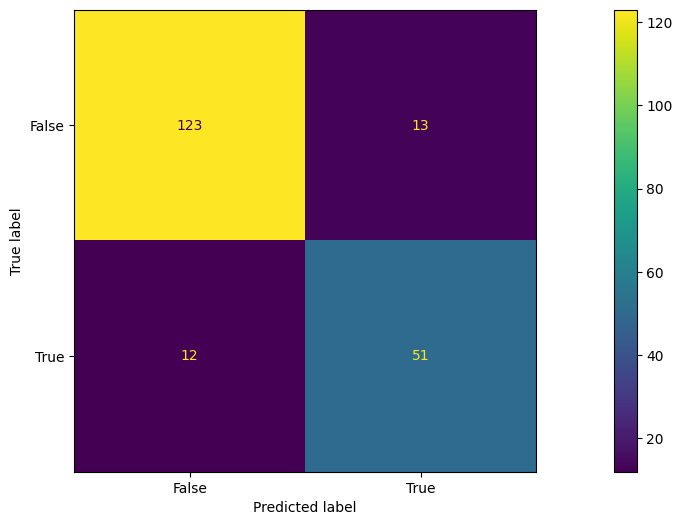

In [254]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()

## Features importance

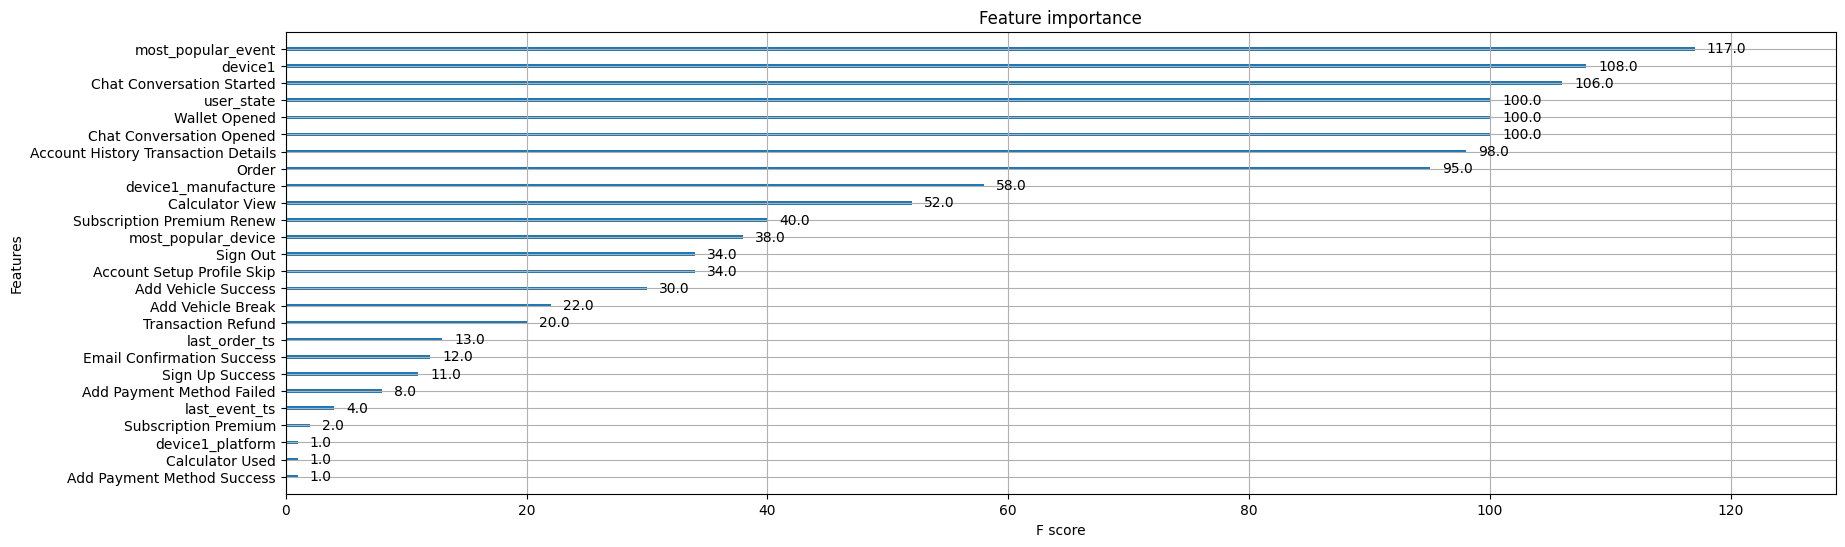

In [255]:
xgb.plot_importance(model)
# xgb.plot_importance(model, importance_type="cover", )
plt.show()

In [256]:
importances = pd.DataFrame.from_dict(dict(zip(users_premium.columns, model.feature_importances_)), orient='index', columns=['Importance']).sort_values("Importance", ascending=False)
importances

,Importance
Chat Conversation Started,0.235872
Subscription Premium Renew,0.175796
num_devices_and_nans,0.061447
Sign Up Success,0.035184
device3,0.034758
Subscription Premium Cancel,0.034150
Account Setup Profile Skip,0.033793
Add Payment Method Failed,0.031718
Chat Conversation Opened,0.030622
Transaction Refund,0.030463
